In [17]:
from __future__ import print_function
import time,os,json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from cs231n.classifiers.squeezenet import SqueezeNet
from cs231n.data_utils import load_tiny_imagenet

from cs231n.image_utils import preprocess_image,deprocess_image
from cs231n.image_utils import SQUEEZENET_MEAN,SQUEEZENET_STD

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0,8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
tf.reset_default_graph()
sess = tf.Session()

SAVE_PATH = 'cs231n/datasets/squeezenet.ckpt'
if not os.path.exists(SAVE_PATH+'.meta'):
    raise ValueError('You need to download SqueezeNet')
    
model = SqueezeNet(save_path=SAVE_PATH,sess=sess)

INFO:tensorflow:Restoring parameters from cs231n/datasets/squeezenet.ckpt


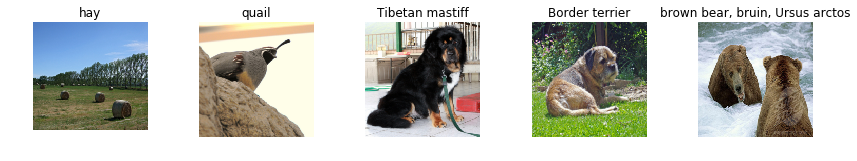

In [19]:
from cs231n.data_utils import load_imagenet_val
X_raw,y,class_names = load_imagenet_val(num=5)

plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_raw[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
    
plt.gcf().tight_layout()

In [4]:
X = np.array([preprocess_image(img) for img in X_raw])

In [5]:
def compute_saliency_maps(X,y,model):
    """
    Compute a class saliency map using the model for images X and labels y.
    
    Input:
    - X: Input images, numpy array of shape (N,H,W,3)
    - y: Labels for X, numpy of shape (N,)
    - model: A SqueezeNet model that will be used to compute the saliency map.
    
    Returns:
    - saliency: A numpy array of shape(N,H,W) giving the saliency maps for the
    input models
    """
    
    saliency = None
    # Compute the score of the correct class for each example.
    # This gives a Tensor with shape [N], the number of example.
    #
    # Note: this is equivalent to scores[np.arrange(N),y] we used in NumPy
    # for computing vectorized losses.
    
    correct_scores = tf.gather_nd(model.scores,tf.stack((tf.range(X.shape[0]),model.labels),axis=1))
    
    loss = correct_scores
    grad_img = tf.gradients(loss,model.image)
    grad_img_val = sess.run(grad_img,feed_dict={model.image:X,model.labels:y})[0]
    saliency = np.amax(np.absolute(grad_img_val),axis=-1)
    
    
    return saliency

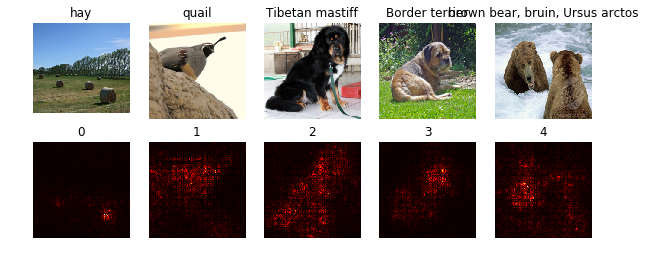

In [6]:
def show_saliency_map(X,y,mask):
    mask = np.asarray(mask)
    Xm = X[mask]
    ym = y[mask]
    
    saliency = compute_saliency_maps(Xm,ym,model)
    
    for i in range(mask.size):
        plt.subplot(2, mask.size, i + 1)
        plt.imshow(deprocess_image(Xm[i]))
        plt.axis('off')
        plt.title(class_names[ym[i]])
        plt.subplot(2, mask.size, mask.size + i + 1)
        plt.title(mask[i])
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(10, 4)
    
mask = np.arange(5)
show_saliency_map(X,y,mask)

In [7]:
def make_fooling_image(X,target_y,model):
    """
    Generate a fooling image that is closed to X, but that the model classifiers
    as target_y.
    
    Inputs:
    - X: Input image,of shape(1,224,224,3)
    - target_y: An integer in the range[0,1000)
    - model: Pretrained Squeezenet model
    
    Returns:
    - X_fooling: An image that is closed to X,but that is classifier as target_y
    by the model.
    """
    X_fooling = X.copy()
    learning_rate = 1
    #############################################################################
    # TODO: Generate a fooling image X_fooling that the model will classify as  #
    # the class target_y. Use gradient ascent on the target class score, using  #
    # the model.scores Tensor to get the class scores for the model.image.      #
    # When computing an update step, first normalize the gradient:              #
    #     dX = learning_rate * g / ||g||_2                                      #
    #                                                                           #
    # You should write a training loop                                          #
    #                                                                           #
    # HINT: For most examples, you should be able to generate a fooling image   #
    # in fewer than 100 iterations of gradient ascent.                          #
    # You can print your progress over iterations to check your algorithm.      #
    #############################################################################
    
    g = tf.gradients(model.scores[0,target_y],model.image)[0]
    dX = learning_rate * g / tf.norm(g)
    
    for i in range(100):
        scores = sess.run(model.scores,{model.image:X_fooling})
        print('step:%d,current_label_score:%f,target_label_score:%f' %
             (i,scores[0].max(),scores[0][target_y]))
        if scores[0].argmax() == target_y:
            break
            
        np_dX = sess.run(dX,feed_dict={model.image:X_fooling})
        X_fooling += np_dX
        
    return X_fooling

step:0,current_label_score:24.131285,target_label_score:5.213544
step:1,current_label_score:25.127638,target_label_score:7.480856
step:2,current_label_score:24.528120,target_label_score:10.226645
step:3,current_label_score:23.690647,target_label_score:13.150136
step:4,current_label_score:22.896656,target_label_score:16.395803
step:5,current_label_score:23.884834,target_label_score:19.390568
step:6,current_label_score:25.508104,target_label_score:22.521635
step:7,current_label_score:27.299322,target_label_score:25.457373
step:8,current_label_score:28.637634,target_label_score:28.185312
step:9,current_label_score:30.926039,target_label_score:30.926039


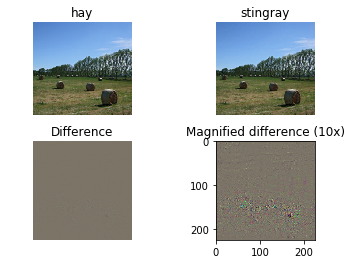

In [8]:
idx = 0
Xi = X[idx][None]
target_y = 6
X_fooling = make_fooling_image(Xi,target_y,model)

# Make sure that X_fooling is classified as y_target
scores = sess.run(model.scores,{model.image:X_fooling})

assert scores[0].argmax() == target_y, 'The network is not fooled!'

# show original image,fooling image, and difference
orig_img = deprocess_image(Xi[0])
fool_img = deprocess_image(X_fooling[0])
# Rescale
plt.subplot(2,2,1)
plt.imshow(orig_img)
plt.axis('off')
plt.title(class_names[y[idx]])
plt.subplot(2,2,2)
plt.imshow(fool_img)
plt.title(class_names[target_y])
plt.axis('off')
plt.subplot(2,2,3)
plt.title('Difference')
plt.imshow(deprocess_image((Xi-X_fooling)[0]))
plt.axis('off')
plt.subplot(2,2,4)
plt.title('Magnified difference (10x)')
plt.imshow(deprocess_image(10 * (Xi-X_fooling)[0]))

In [9]:
from scipy.ndimage.filters import gaussian_filter1d
def blur_image(X,sigma=1):
    X = gaussian_filter1d(X,sigma,axis=1)
    X = gaussian_filter1d(X,sigma,axis=2)
    return X

In [14]:

def create_class_visualization(target_y,model,**kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range[0,1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many itertions to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to jitter the image as an implict regularizer
    - show_every: How often to show the intermediate result
    """
    l2_reg = kwargs.pop('l2_reg',1e-3)
    learning_rate = kwargs.pop('learning_rate',25)
    num_iterations = kwargs.pop('num_interations',100)
    blur_every = kwargs.pop('blur_every',10)
    max_jitter = kwargs.pop('max_jitter',16)
    show_every = kwargs.pop('show_every',25)
    
    X = 255*np.random.rand(224,224,3)
    X = preprocess_image(X)[None]
    
    ########################################################################
    # TODO: Compute the loss and the gradient of the loss with respect to  #
    # the input image, model.image. We compute these outside the loop so   #
    # that we don't have to recompute the gradient graph at each iteration #
    #                                                                      #
    # Note: loss and grad should be tensorflow tensors, not numpy arrays!  #
    #                                                                      #
    # The loss is the score for the target label, target_y. You should     #
    # use model.scores to get the scores, and tf.gradients to compute      #
    # gradients. Don't forget the (subtracted) L2 regularization term!     #
    ########################################################################
    
    loss = model.scores[0][target_y]
    l2_reg_tensor = tf.constant(l2_reg)
    loss = tf.subtract(loss,tf.multiply(l2_reg_tensor,tf.norm(model.image)))
    grad = tf.gradients(loss,model.image)[0]
    
    ##########################################################################
    
    #                             END OF YOUR CODE                           #
    
    ##########################################################################
    
    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter,max_jitter,2)
        
        Xi = X.copy()
        X = np.roll(np.roll(X,ox,1),oy,2)
        
        #########################################################################
        # TODO: Use sess to compute the value of the gradient of the score for  #
        # class target_y with respect to the pixels of the image, and make a    #
        # gradient step on the image using the learning rate. You should use    #
        # the grad variable you define above                                    #
        #                                                                       #
        # Be very careful about the sign of elements in your code               #
        #########################################################################
        gradient = sess.run(grad,{model.image:X})
        dx = learning_rate*gradient
        X = X + dx
        # Undo the jitter
        X = np.roll(np.roll(X,-ox,1),-oy,2)
        
        # As a regularizer, clip and periodically blur
        X = np.clip(X,-SQUEEZENET_MEAN/SQUEEZENET_STD,(1.0 - SQUEEZENET_MEAN)/SQUEEZENET_STD)
        if t % blur_every == 0:
            X = blur_image(X,sigma=0.5)
        
        if t==0 or (t+1) % show_every ==0 or t==num_iterations -1:
            plt.imshow(deprocess_image(X[0]))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' %(class_name,t+1,num_iterations))
            plt.gcf().set_size_inches(4,4)
            plt.axis('off')
            plt.show()
    return X

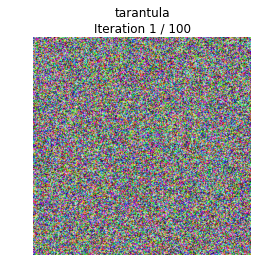

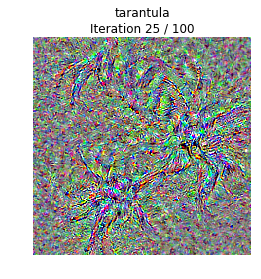

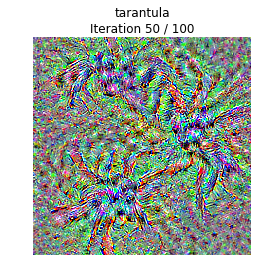

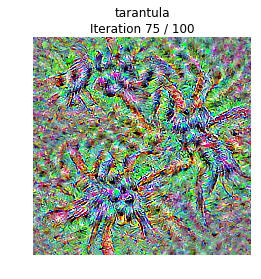

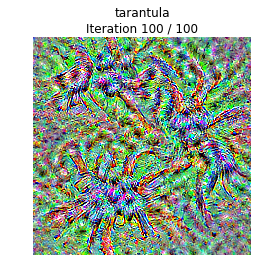

In [15]:
target_y = 76
out = create_class_visualization(target_y, model)

chain


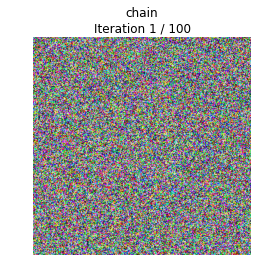

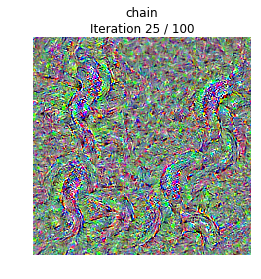

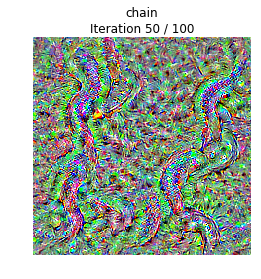

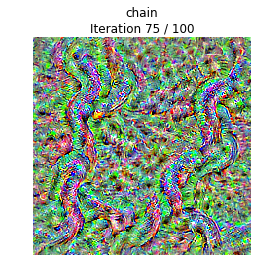

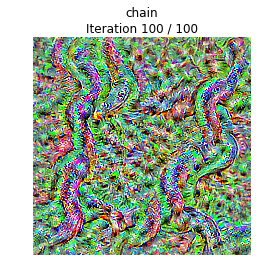

In [16]:
target_y = np.random.randint(1000)
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
print(class_names[target_y])
X = create_class_visualization(target_y, model)